### Imports

In [ ]:
# installing darts libarary, for google colab
!pip install darts

In [ ]:
# Import necessary libraries and functions
import numpy as np
import pandas as pd
import torch
import pickle
import time
from scipy.io import loadmat
#from google.colab import files


#%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

import torch.optim as optim

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, TCNModel, ARIMA
from darts.metrics import mape, rmse, r2_score, mase, mse
from darts.utils.likelihood_models import GaussianLikelihood

from darts.utils.model_selection import train_test_split
from darts.timeseries import TimeSeries as ts
from darts.models.forecasting.transformer_model import TransformerModel


In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print(device)
    print(f"GPU is available - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

cuda
GPU is available - Tesla T4


# Models Training

In [ ]:
# for all darts models
input_chunk = 20
stride = 20

## Exchange

In [ ]:
epochs_num_ex = 10

In [ ]:
# PreProcess - import the data as Time Series
ex_ts = ts.from_csv('exchange_rate.csv', value_cols=['0', '1', '2', '3', '4', '5', '6', 'OT'])
ex_train_ts, ex_test_ts = train_test_split(ex_ts, test_size=0.25)

In [ ]:
def model_training_exchange(model, epochs, train_ts, test_ts, input_chunk=20,  stride=20):
  train_mse = []
  test_mse = []
  for epoch in range(epochs):

    model.fit(train_ts, verbose=True, epochs=1)
    # checking the error on the train set, predict "forecast_horizon" time steps every "stride" time steps and calc the mse
    train_curr_err = model.backtest(train_ts, num_samples=1, train_length=None, start=None, forecast_horizon=1, stride=stride, retrain=False, metric=mse)
    train_mse.append(train_curr_err)
    # checking the error on the test set, predict "forecast_horizon" time steps every "stride" time steps and calc the mse
    test_curr_err = model.backtest(test_ts, num_samples=1, train_length=None, start=None, forecast_horizon=1, stride=stride, retrain=False, metric=mse)
    test_mse.append(test_curr_err)
    print(f"epoch number {epoch+1} - train loss:{train_mse[-1]}, test loss:{test_mse[-1]}")
  return train_mse, test_mse



#### ARIMA

In [ ]:
# taking only the last column because ARIMA is univariate
ex_train_ot = ex_train_ts.drop_columns(ex_train_ts.columns[0:7]) 
ex_test_ot = ex_test_ts.drop_columns(ex_test_ts.columns[0:7])

In [ ]:
ex_arima = ARIMA(p=3, d=1, q=3, trend=None, add_encoders=None) 
ex_arima.fit(ex_train_ot)

In [ ]:
# checking the error on the train and test sets, predict "forecast_horizon" time steps every "stride" time steps and calc the mse
ex_train_mse_arima = ex_arima.backtest(ex_train_ot, forecast_horizon=1, retrain=False, stride=stride, metric=mse)
ex_test_mse_arima = ex_arima.backtest(ex_test_ot, forecast_horizon=1, retrain=False, stride=stride, metric=mse)
print(f'The train error is {ex_train_mse_arima}')
# The train error is 1.7293536464405334e-05
print(f'The test error is {ex_test_mse_arima}')
# The test error is 2.2193917678314702e-05

The train error is 1.7293877458497685e-05
The test error is 2.2193739691758155e-05


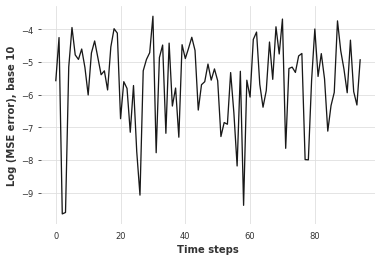

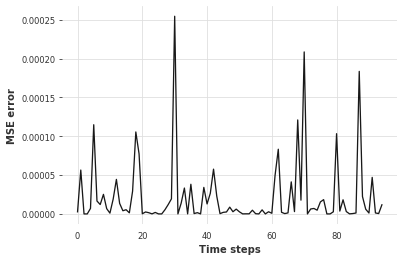

In [ ]:
# plot arima errors - ex
err_per_time_step = ex_arima.backtest(ex_test_ot, forecast_horizon=1, retrain=False, stride=stride, metric=mse, reduction=None)

plt.plot(range(0,len(err_per_time_step)), np.log10(err_per_time_step), alpha=0.9, color = 'black')
plt.xlabel('Time steps')
plt.ylabel('Log (MSE error), base 10')
plt.legend()
plt.savefig(f"exe_arima_mse_log10.png", dpi=500)
plt.show()

plt.plot(range(0,len(err_per_time_step)), err_per_time_step, alpha=0.9, color = 'black')
plt.xlabel('Time steps')
plt.ylabel('MSE error')
plt.legend()
plt.savefig(f"exe_arima_mse.png", dpi=500)
plt.show()

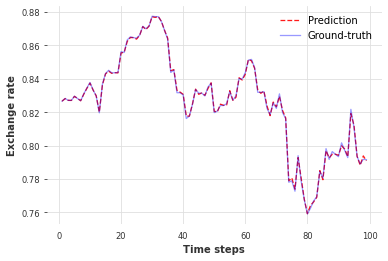

In [ ]:
# plot arima example - ex
series_range = range(1,100)
prd_lst = []
for i in series_range:
    prd_lst.append(ex_arima.predict(1, ex_test_ot[0:i]).values().squeeze())

#plt.scatter(series_range, prd_lst, label='Predicted', color = 'red')
plt.plot(series_range, prd_lst, label='Prediction', alpha=0.9, color = 'red' , linestyle='dashed')
plt.plot(series_range, ex_test_ot[0:i].values().squeeze(),  'r-',label='Ground-truth', alpha=0.4, color = 'blue')
plt.xlabel('Time steps')
plt.ylabel('Exchange rate')
plt.legend()
plt.savefig(f"exe_arima_example.png", dpi=500)
plt.show()

#### RNN

In [ ]:
ex_rnn = RNNModel(
    model='RNN',
    model_name='Vanilla RNN',
    hidden_dim=100,
    batch_size=16,
    n_rnn_layers=2,
    n_epochs=epochs_num_ex,
    dropout=0,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    input_chunk_length=input_chunk,
    output_chunk_length=1,
    loss_fn=torch.nn.MSELoss(),
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)

In [ ]:
ex_train_mse_rnn, ex_test_mse_rnn =  model_training_exchange(model=ex_rnn,
                                                              epochs=epochs_num_ex,
                                                              train_ts=ex_train_ts,
                                                              test_ts=ex_test_ts,
                                                              input_chunk=input_chunk,
                                                              stride=stride)

Training: 0it [00:00, ?it/s]

epoch number 1 - train loss:0.0010529763579228612, test loss:0.0019182572367217288


Training: 0it [00:00, ?it/s]

epoch number 2 - train loss:0.0005151825679680537, test loss:0.0013881305546999058


Training: 0it [00:00, ?it/s]

epoch number 3 - train loss:0.00022212960958697421, test loss:0.0004353004485757421


Training: 0it [00:00, ?it/s]

epoch number 4 - train loss:0.0001288189378206459, test loss:0.0004308885217670644


Training: 0it [00:00, ?it/s]

epoch number 5 - train loss:0.00010910312743384686, test loss:0.0003754835241753745


Training: 0it [00:00, ?it/s]

epoch number 6 - train loss:9.590466122517408e-05, test loss:0.0003030365155850007


Training: 0it [00:00, ?it/s]

epoch number 7 - train loss:7.687707446918898e-05, test loss:0.00028754082564279586


Training: 0it [00:00, ?it/s]

epoch number 8 - train loss:6.8355984103671e-05, test loss:0.0002601224454703253


Training: 0it [00:00, ?it/s]

epoch number 9 - train loss:8.658247438815635e-05, test loss:0.000283961348258997


Training: 0it [00:00, ?it/s]

epoch number 10 - train loss:5.9723649502760586e-05, test loss:0.00022231933377755864


#### TCN

In [ ]:
ex_tcn = TCNModel(
    input_chunk_length=input_chunk,
    output_chunk_length=1,
    n_epochs=epochs_num_ex,
    dropout=0,
    dilation_base=5,
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)

In [ ]:
ex_train_mse_tcn, ex_test_mse_tcn =  model_training_exchange(model=ex_tcn,
                                                                          epochs=epochs_num_ex,
                                                                          train_ts=ex_train_ts,
                                                                          test_ts=ex_test_ts,
                                                                          input_chunk=input_chunk,
                                                                          stride=stride)

Training: 0it [00:00, ?it/s]

epoch number 1 - train loss:0.007674463751749724, test loss:0.03191134434715105


Training: 0it [00:00, ?it/s]

epoch number 2 - train loss:0.002797408086029021, test loss:0.011621614449672782


Training: 0it [00:00, ?it/s]

epoch number 3 - train loss:0.0013423988480687206, test loss:0.0034692348784408893


Training: 0it [00:00, ?it/s]

epoch number 4 - train loss:0.0009084676845090997, test loss:0.0022571504114883814


Training: 0it [00:00, ?it/s]

epoch number 5 - train loss:0.0006661316482778646, test loss:0.001459159547387043


Training: 0it [00:00, ?it/s]

epoch number 6 - train loss:0.000529133502683977, test loss:0.0014272821130555736


Training: 0it [00:00, ?it/s]

epoch number 7 - train loss:0.0004339150523087642, test loss:0.0013254187754292099


Training: 0it [00:00, ?it/s]

epoch number 8 - train loss:0.0004167621708811826, test loss:0.0012331793286579867


Training: 0it [00:00, ?it/s]

epoch number 9 - train loss:0.0003377357049806891, test loss:0.0010553205369300842


Training: 0it [00:00, ?it/s]

epoch number 10 - train loss:0.00030119901480846873, test loss:0.001035142058140357


#### Transformers

In [ ]:
ex_transformer = TransformerModel(
    input_chunk_length=input_chunk,
    output_chunk_length=1,
    n_epochs=epochs_num_ex,
    loss_fn=torch.nn.MSELoss(),
    log_tensorboard=False,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]})

In [ ]:
ex_train_mse_transformer, ex_test_mse_transformer =  model_training_exchange(model=ex_transformer,
                                                                          epochs=epochs_num_ex,
                                                                          train_ts=ex_train_ts,
                                                                          test_ts=ex_test_ts,
                                                                          input_chunk=input_chunk,
                                                                          stride=stride)

Training: 0it [00:00, ?it/s]

epoch number 1 - train loss:0.005075602745631479, test loss:0.005758755549971242


Training: 0it [00:00, ?it/s]

epoch number 2 - train loss:0.0015922822412028957, test loss:0.005246587356558373


Training: 0it [00:00, ?it/s]

epoch number 3 - train loss:0.0011762421132327607, test loss:0.003976238999178639


Training: 0it [00:00, ?it/s]

epoch number 4 - train loss:0.0007888370989367846, test loss:0.003156870863035584


Training: 0it [00:00, ?it/s]

epoch number 5 - train loss:0.0005806896310131414, test loss:0.0021814771877856553


Training: 0it [00:00, ?it/s]

epoch number 6 - train loss:0.0007767592584844745, test loss:0.0021106815277881236


Training: 0it [00:00, ?it/s]

epoch number 7 - train loss:0.0007181134277390856, test loss:0.002099462708845591


Training: 0it [00:00, ?it/s]

epoch number 8 - train loss:0.00045808556432487, test loss:0.002180049382053725


Training: 0it [00:00, ?it/s]

epoch number 9 - train loss:0.00032994451195608265, test loss:0.002059035977093103


Training: 0it [00:00, ?it/s]

epoch number 10 - train loss:0.0005220104328313394, test loss:0.0017136843470340892


## JSB Chorales

In [ ]:
from scipy.io import loadmat
import numpy as np

import torch.nn as nn
from torch.nn.utils import weight_norm

from torch.autograd import Variable
import torch.optim as optim

In [ ]:
epochs_num_jsb = 10
jsb_dim = 88

In [ ]:
def array_to_timeseries_list(arr):
  ts_lst = []
  for i in range(len(arr)):
    ts_lst.append(ts.from_values(arr[i]))
  return ts_lst

In [ ]:
# PreProcess

# for ARIMA model
jsb = loadmat('JSB_Chorales.mat')
jsb_train = jsb['traindata'][0]
jsb_val = jsb['validdata'][0]
jsb_test = jsb['testdata'][0]
jsb_train_ts = array_to_timeseries_list(jsb_train)
jsb_test_ts = array_to_timeseries_list(jsb_test)
jsb_val_ts = array_to_timeseries_list(jsb_val)

# for the rest of the models
X_train = jsb_train
X_valid = jsb_val
X_test = jsb_test

# casting data to tensor
for data in [X_train, X_valid, X_test]:
    for i in range(len(data)):
        data[i] = torch.Tensor(data[i].astype(np.float64))

#### ARIMA

In [ ]:
# NLL loss for the ARIMA model
def negative_log_likelihood(y_true_ts, y_pred_ts):
  # y_true and y_pred are expected to be numpy arrays with the same shape
  # and dtype.
  index = y_pred_ts.time_index.start
  y_true = y_true_ts[0][index].values()[0][0]
  y_pred = y_pred_ts.values()[0][0]
  
  eps = 1e-15  # small constant to avoid log(0)
  y_pred = np.maximum(y_pred, eps)  # clip predicted values at eps
  y_pred = np.minimum(y_pred, 1 - eps)  # clip predicted values at 1 - eps
  return -(y_true * np.log(y_pred) +  (1-y_true)*np.log(1-y_pred))

In [ ]:
# concatenate all the series in the train and test to one long series for train and one for
# test because ARIMA model fit only to one series, while padding with <stride> zeros between every two series.
conc_jsb_train_ts = jsb_train_ts[0]
conc_jsb_test_ts = jsb_test_ts[0]
zeroes = np.zeros((stride+1,88))
ts_zeroes = ts.from_values(zeroes)
for i in range(1, len(jsb_train_ts)):
    conc_jsb_train_ts = conc_jsb_train_ts.concatenate(ts_zeroes,ignore_time_axis=True)
    conc_jsb_train_ts = conc_jsb_train_ts.concatenate(jsb_train_ts[i],ignore_time_axis=True)
    
for i in range(1, len(jsb_test_ts)):
    conc_jsb_test_ts = conc_jsb_test_ts.concatenate(ts_zeroes,ignore_time_axis=True)
    conc_jsb_test_ts = conc_jsb_test_ts.concatenate(jsb_test_ts[i],ignore_time_axis=True)

In [ ]:
# return the specific column as univariate time series
def create_column_series(conc_jsb, col_num):
    jsb_i = conc_jsb.drop_columns(conc_jsb.columns[0:col_num])
    if col_num != 87:
        jsb_i = jsb_i.drop_columns(jsb_i.columns[1:])
    return jsb_i

In [ ]:
def get_arima_errors_jsb():
  '''create one model ARIMA for each column in the vector time series, each ARIMA
   model fit to each column and the NLL error is computed on the train and test sets'''
    err_train_i_lst = []
    err_test_i_lst = []
    for i in range(0,jsb_dim):
        print(f'ARIMA model for dim {i+1}')
        jsb_train_i = create_column_series(conc_jsb_train_ts, i) 
        jsb_test_i = create_column_series(conc_jsb_test_ts, i) 
        jsb_arima_i = ARIMA(p=3, d=1, q=3, trend=None, add_encoders=None)
        jsb_arima_i.fit(jsb_train_i)
        err_train_i_lst.append(jsb_arima_i.backtest(jsb_train_i,retrain=False, forecast_horizon=1,stride=stride*32, metric=negative_log_likelihood))
        err_test_i_lst.append(jsb_arima_i.backtest(jsb_test_i,retrain=False, forecast_horizon=1,stride=stride*32, metric=negative_log_likelihood))
    jsb_arima_train_nll = np.sum(err_train_i_lst)
    jsb_arima_test_nll = np.sum(err_test_i_lst)
    print(f'train error (NLL) : {jsb_arima_train_nll}')
    print(f'test error (NLL) : {jsb_arima_test_nll}')
    return jsb_arima_train_nll, jsb_arima_test_nll

#jsb_arima_train_nll, jsb_arima_test_nll = get_arima_errors_jsb()

jsb_arima_train_nll =  7.83818777366927
jsb_arima_test_nll = 9.210561876092054

print(f'The train error is {jsb_arima_train_nll}')
# The train error is 7.83818777366927
print(f'The test error is {jsb_arima_test_nll}')
# The test error is 9.210561876092054

The train error is 7.83818777366927
The test error is 9.210561876092054


### Using Darts Library

In [ ]:
# !pip install pytorch_lightning
# from pytorch_lightning.callbacks import Callback
# # call back for pytorch lightning - issue from darts repository
# class LossLogger(Callback):
#     def __init__(self):
#         self.train_loss = []
#         self.test_loss = []

#     def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
#         self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

#     def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
#         self.test_loss.append(float(trainer.callback_metrics["val_loss"]))

#### RNN

In [ ]:
# record_loss_rnn = LossLogger()
# jsb_rnn = RNNModel(
#     model='RNN',
#     model_name='Vanilla RNN',
#     batch_size=16,
#     n_epochs=epochs_num_jsb,
#     dropout=0,
#     optimizer_kwargs={'lr': 1e-4},
#     # log_tensorboard=True,
#     # random_state=42,
#     # force_reset=True,
#     input_chunk_length=input_chunk,
#     output_chunk_length=1,
#     loss_fn=torch.nn.CrossEntropyLoss(),
#     pl_trainer_kwargs={
#       "accelerator": "gpu",
#       "devices": [0],
#       "callbacks" : [record_loss_rnn]
#     }
# )
#jsb_rnn.fit(jsb_train_ts, val_series=jsb_test_ts, verbose=True, epochs=epochs_num_jsb)


#### TCN

In [ ]:
# record_loss_tcn = LossLogger()
# jsb_tcn = TCNModel(
#     input_chunk_length=input_chunk,
#     output_chunk_length=1,
#     n_epochs=epochs_num_jsb,
#     dropout=0,
#     dilation_base=2,
#     weight_norm=True,
#     kernel_size=3,
#     num_filters=6,
#     loss_fn=torch.nn.CrossEntropyLoss(),
#     nr_epochs_val_period=1,
#     random_state=0,
#     pl_trainer_kwargs={
#       "accelerator": "gpu",
#       "devices": [0],
#       "callbacks": [record_loss_tcn]
#     }
# )
#jsb_tcn.fit(jsb_train_ts, val_series=jsb_test_ts, verbose=True, epochs=epochs_num_jsb)

#### Transformers

In [ ]:
# record_loss_transformer = LossLogger()
# jsb_transformer = TransformerModel(
#     input_chunk_length=input_chunk,
#     output_chunk_length=2,
#     n_epochs=epochs_num_jsb,
#     loss_fn=torch.nn.CrossEntropyLoss(),
#     log_tensorboard=False,
#     pl_trainer_kwargs={
#       "accelerator": "gpu",
#       "devices": [0],
#       "callbacks": [record_loss_transformer]
#     }
#     )
#jsb_transformer.fit(jsb_train_ts, val_series=jsb_test_ts, verbose=True, epochs=epochs_num_jsb)

### Using Pytorch Library

#### RNN

In [ ]:
# number of points
hidden_size = 150
input_size = jsb_dim
number_of_layers = 3
output_size = jsb_dim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.number_of_layers = number_of_layers
        self.output_size = output_size

        self.rnn = nn.RNN(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.number_of_layers,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
        # Add a softmax layer
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x, hidden_prev):
        #h0 = self.init_hidden_state() # we found out that it is better not to reinialized 
        hidden_prev = hidden_prev.to(device)
        #out, hidden_prev = self.rnn(x, h0)
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, self.hidden_size)  # stack batch and seq
 
        out = self.linear(out) 
        
        
        out = out.unsqueeze(dim=0)  
        
        # Apply the softmax layer
        out = self.softmax(out)
        return out, hidden_prev
    
    def init_hidden_state(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        initial_hidden = torch.zeros(self.number_of_layers, self.hidden_size).to(device) # [b, layer, mem_size]
        return initial_hidden

#### TCN

In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x.transpose(1, 2)).transpose(1, 2)
        output = self.linear(output).double()
        return self.sig(output)

#### Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# The input to the model is a sequence of multivariate time series with shape (batch_size, sequence_length, num_features)
# The output is a sequence of forecasts for the next time step, with shape (batch_size, sequence_length, num_features)

# Define the transformer model
class Transformer(nn.Module):
    def __init__(self, num_features, num_heads, hidden_size, num_layers, dropout=0.1):
        super().__init__()

        # Create the encoder and decoder layers
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(num_features, num_heads, hidden_size, dropout)
            for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(num_features, num_heads, hidden_size, dropout)
            for _ in range(num_layers)
        ])

        # Create the final projection layer
        self.final_projection = nn.Linear(num_features, num_features)
        
        # Add a softmax layer
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # Encode the input sequence
        x = x.transpose(0, 1)  # shape: (sequence_length, batch_size, num_features)
        encoded_x = x
        for encoder_layer in self.encoder_layers:
            encoded_x = encoder_layer(encoded_x)

        # Decode the encoded sequence
        decoded_x = encoded_x
        for decoder_layer in self.decoder_layers:
            decoded_x = decoder_layer(decoded_x, encoded_x)

        # Apply the final projection layer
        forecast = self.final_projection(decoded_x)
        
        # Apply the softmax layer
        forecast = self.softmax(forecast)

        # Transpose the output back to the original shape
        forecast = forecast.transpose(0, 1)  # shape: (batch_size, sequence length, num_features)

        return forecast

#### Train and Evaluate RNN

In [ ]:
model = Net()
hidden_prev_init = model.init_hidden_state()

if is_cuda:
    model.cuda()

lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr)


def evaluate(X_data,hidden_prev, name='Test'):
    model.eval()
    eval_idx_list = np.arange(len(X_data), dtype="int32")
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for idx in eval_idx_list:
            data_line = X_data[idx]
            x, y = Variable(data_line[:-1]), Variable(data_line[1:])
            if is_cuda:
                x, y = x.cuda(), y.cuda()
            output, hidden_prev = model(x, hidden_prev)
            hidden_prev = hidden_prev.detach()
            output= output.squeeze(0)
            output = torch.clip(output, 1e-15, 1 - 1e-15)  # avoid division by zero and numerical instability
            loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                                torch.matmul((1-y), torch.log(1-output).float().t()))
            total_loss += loss.item()
            count += output.size(0)
        eval_loss = total_loss / count
        print(name + " loss: {:.5f}".format(eval_loss))
        return eval_loss


def train(ep, hidden_prev):
    model.train()
    total_loss = 0
    count = 0
    train_idx_list = np.arange(len(X_train), dtype="int32")
    np.random.shuffle(train_idx_list)
    for idx in train_idx_list:
        data_line = X_train[idx]
        x, y = Variable(data_line[:-1]), Variable(data_line[1:])
        if is_cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        # output = model(x.unsqueeze(0)).squeeze(0) # [1, 51, 88]
        
        
        output, hidden_prev = model(x, hidden_prev) # [b, seq_len, fea_len] [1, 51, 88]
        hidden_prev = hidden_prev.detach()
        output= output.squeeze(0)
        output = torch.clip(output, 1e-15, 1 - 1e-15)  # avoid division by zero and numerical instability

        
        loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                            torch.matmul((1 - y), torch.log(1 - output).float().t()))
        total_loss += loss.item()
        count += output.size(0)

        loss.backward()
        optimizer.step()



vloss_list_rnn = []
trainloss_list_rnn = []
testloss_list_rnn = []
for ep in range(1, epochs_num_jsb+1):
    train(ep, hidden_prev_init)
    print(f'epoch {ep}')
    vloss = evaluate(X_valid,hidden_prev_init, name='Validation')
    trainloss_list_rnn.append(evaluate(X_train,hidden_prev_init, name='Train'))
    testloss_list_rnn.append(evaluate(X_test,hidden_prev_init, name='Test'))
    print()
    if ep > 10 and vloss > max(vloss_list_rnn[-3:]):
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    vloss_list_rnn.append(vloss)

print('-' * 89)
tloss = evaluate(X_test, hidden_prev_init)



epoch 1
Validation loss: 13.73715
Train loss: 13.90425
Test loss: 13.85359

epoch 2
Validation loss: 13.64000
Train loss: 13.81470
Test loss: 13.75695

epoch 3
Validation loss: 13.61431
Train loss: 13.78902
Test loss: 13.73214

epoch 4
Validation loss: 13.60630
Train loss: 13.77781
Test loss: 13.71690

epoch 5
Validation loss: 13.60982
Train loss: 13.78285
Test loss: 13.72053

epoch 6
Validation loss: 13.27270
Train loss: 13.47640
Test loss: 13.42869

epoch 7
Validation loss: 13.00662
Train loss: 13.24448
Test loss: 13.18507

epoch 8
Validation loss: 12.78863
Train loss: 12.99712
Test loss: 12.94245

epoch 9
Validation loss: 12.64447
Train loss: 12.82670
Test loss: 12.78164

epoch 10
Validation loss: 12.53941
Train loss: 12.71149
Test loss: 12.66427

-----------------------------------------------------------------------------------------
Test loss: 12.66427


##### Train and Evaluate TCN

In [ ]:
n_channels = [30] * 2
kernel_size = 4
dropout = 0.3

model = TCN(input_size, input_size, n_channels, kernel_size, dropout=dropout)



if is_cuda:
    model.cuda()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr)


def evaluate(X_data, name='Test'):
    model.eval()
    eval_idx_list = np.arange(len(X_data), dtype="int32")
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for idx in eval_idx_list:
            data_line = X_data[idx]
            x, y = Variable(data_line[:-1]), Variable(data_line[1:])
            if is_cuda:
                x, y = x.cuda(), y.cuda()
            output = model(x.unsqueeze(0)).squeeze(0)
            loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                                torch.matmul((1-y), torch.log(1-output).float().t()))
            total_loss += loss.item()
            count += output.size(0)
        eval_loss = total_loss / count
        print(name + " loss: {:.5f}".format(eval_loss))
        return eval_loss


def train(ep):
    model.train()
    total_loss = 0
    count = 0
    train_idx_list = np.arange(len(X_train), dtype="int32")
    np.random.shuffle(train_idx_list)
    for idx in train_idx_list:
        data_line = X_train[idx]
        x, y = Variable(data_line[:-1]), Variable(data_line[1:])
        if is_cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        output = model(x.unsqueeze(0)).squeeze(0)
        
        loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                            torch.matmul((1 - y), torch.log(1 - output).float().t()))
        total_loss += loss.item()
        count += output.size(0)

        loss.backward()
        optimizer.step()



vloss_list_tcn = []
trainloss_list_tcn = []
testloss_list_tcn = []
for ep in range(1, epochs_num_jsb+1):
    train(ep)
    print(f'epoch {ep}')
    vloss = evaluate(X_valid, name='Validation')
    trainloss_list_tcn.append(evaluate(X_train, name='Train'))
    testloss_list_tcn.append(evaluate(X_test, name='Test'))
    print()
    if ep > 10 and vloss > max(vloss_list_tcn[-3:]):
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    vloss_list_tcn.append(vloss)

print('-' * 89)
tloss = evaluate(X_test)


epoch 1
Validation loss: 16.32410
Train loss: 16.41049
Test loss: 16.33852

epoch 2
Validation loss: 12.95702
Train loss: 13.07091
Test loss: 13.01346

epoch 3
Validation loss: 12.03148
Train loss: 12.14640
Test loss: 12.10589

epoch 4
Validation loss: 11.60552
Train loss: 11.72009
Test loss: 11.67673

epoch 5
Validation loss: 11.37712
Train loss: 11.48748
Test loss: 11.44858

epoch 6
Validation loss: 11.19178
Train loss: 11.30679
Test loss: 11.26843

epoch 7
Validation loss: 11.06820
Train loss: 11.18784
Test loss: 11.15036

epoch 8
Validation loss: 10.98426
Train loss: 11.10010
Test loss: 11.06335

epoch 9
Validation loss: 10.89969
Train loss: 11.01649
Test loss: 10.98233

epoch 10
Validation loss: 10.79865
Train loss: 10.92014
Test loss: 10.88960

-----------------------------------------------------------------------------------------
Test loss: 10.88960


#### Train and Evaluate Transformer

In [ ]:
# Create the transformer model and the optimizer
model = Transformer(jsb_dim, 2, hidden_size, 4)
if is_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters())


def evaluate(X_data,hidden_prev, name='Test'):
    model.eval()
    eval_idx_list = np.arange(len(X_data), dtype="int32")
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for idx in eval_idx_list:
            data_line = X_data[idx]
            x, y = Variable(data_line[:-1]), Variable(data_line[1:])
            if is_cuda:
                x, y = x.cuda(), y.cuda()
            x = torch.tensor(x).float().reshape(1, x.shape[0], jsb_dim)  # [b, seq_len, fea_len]
            # Forward pass
            output = model(x)

            # Compute the loss
            #loss = negative_log_likelihood(output, y)
            
            output= output.squeeze(0)
            #output = torch.clip(output, 1e-15, 1 - 1e-15)  # avoid division by zero and numerical instability
            loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                                torch.matmul((1-y), torch.log(1-output).float().t()))
            total_loss += loss.item()
            count += output.size(0)
        eval_loss = total_loss / count
        print(name + " loss: {:.5f}".format(eval_loss))
        return eval_loss


def train(ep, hidden_prev):
    model.train()
    total_loss = 0
    count = 0
    train_idx_list = np.arange(len(X_train), dtype="int32")
    np.random.shuffle(train_idx_list)
    for idx in train_idx_list:
        data_line = X_train[idx]
        x, y = Variable(data_line[:-1]), Variable(data_line[1:])
        if is_cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        # output = model(x.unsqueeze(0)).squeeze(0) # [1, 51, 88]
        
        x = torch.tensor(x).float().reshape(1, x.shape[0], jsb_dim)  # [b, seq_len, fea_len]
        # Forward pass
        output = model(x)

        # Compute the loss
        #loss = negative_log_likelihood(output, y)
        
        output= output.squeeze(0)
        #output = torch.clip(output, 1e-15, 1 - 1e-15)  # avoid division by zero and numerical instability
        
        loss = -torch.trace(torch.matmul(y, torch.log(output).float().t()) +
                            torch.matmul((1 - y), torch.log(1 - output).float().t()))
        total_loss += loss.item()
        
        count += output.size(0)

        loss.backward()
        optimizer.step()



vloss_list_transformer = []
trainloss_list_transformer = []
testloss_list_transformer = []
for ep in range(1, epochs_num_jsb+1):
    train(ep, hidden_prev_init)
    print(f'epoch {ep}')
    vloss = evaluate(X_valid,hidden_prev_init, name='Validation')
    trainloss_list_transformer.append(evaluate(X_train,hidden_prev_init, name='Train'))
    testloss_list_transformer.append(evaluate(X_test,hidden_prev_init, name='Test'))
    print()
    if ep > 10 and vloss > max(vloss_list_transformer[-3:]):
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    vloss_list_transformer.append(vloss)

print('-' * 89)
tloss = evaluate(X_test, hidden_prev_init)

epoch 1
Validation loss: 12.69013
Train loss: 12.88753
Test loss: 12.80022

epoch 2
Validation loss: 12.10116
Train loss: 12.11904
Test loss: 12.17259

epoch 3
Validation loss: 11.70741
Train loss: 11.61934
Test loss: 11.78512

epoch 4
Validation loss: 11.47563
Train loss: 11.29321
Test loss: 11.60708

epoch 5
Validation loss: 11.39703
Train loss: 11.12210
Test loss: 11.49880

epoch 6
Validation loss: 11.29080
Train loss: 10.85854
Test loss: 11.41676

epoch 7
Validation loss: 11.21405
Train loss: 10.71690
Test loss: 11.31859

epoch 8
Validation loss: 11.19250
Train loss: 10.44657
Test loss: 11.28631

epoch 9
Validation loss: 11.12086
Train loss: 10.26578
Test loss: 11.23420

epoch 10
Validation loss: 11.09598
Train loss: 10.09122
Test loss: 11.21323

-----------------------------------------------------------------------------------------
Test loss: 11.21323


## Figuers

In [ ]:
# load or save pkl

# with open('all_ex_lsts.pkl', 'rb') as f:
#    all_exe_lsts = pickle.load(f)
# ex_train_mse_rnn, ex_test_mse_rnn, ex_train_mse_tcn, ex_test_mse_tcn, ex_train_mse_transformer, ex_test_mse_transformer = all_exe_lsts

# with open('all_pytorch_jsb_lsts.pkl', 'rb') as f:
#    all_pytorch_jsb_lsts = pickle.load(f)
# trainloss_list_rnn, testloss_list_rnn ,trainloss_list_tcn, testloss_list_tcn, trainloss_list_transformer, testloss_list_transformer = all_pytorch_jsb_lsts

all_ex_lsts = [ex_train_mse_arima,ex_test_mse_arima,ex_train_mse_rnn, ex_test_mse_rnn, ex_train_mse_tcn, ex_test_mse_tcn, ex_train_mse_transformer, ex_test_mse_transformer]
#all_jsb_lsts = [jsb_arima_train_nll, jsb_arima_test_nll, record_loss_rnn, record_loss_tcn, record_loss_transformer ]
all_pytorch_jsb_lsts = [trainloss_list_rnn, testloss_list_rnn ,trainloss_list_tcn, testloss_list_tcn, trainloss_list_transformer, testloss_list_transformer]


# with open('./all_ex_lsts.pkl', 'wb') as f:
#   pickle.dump(all_ex_lsts, f)
  
# with open('./all_pytorch_jsb_lsts.pkl', 'wb') as f:
#   pickle.dump(all_pytorch_jsb_lsts, f)

In [ ]:
def plot_err_train_test(db_name, model_name, err_train_lst, err_test_lst, log10=True):
    log10_str= ''
    y_label  = 'Prediction error'
    if log10:
        plt.plot(np.arange(len(err_train_lst)), np.log10(err_train_lst), label=f'train_{model_name}', alpha=0.7, color = 'blue')
        plt.plot(np.arange(len(err_test_lst)), np.log10(err_test_lst), label=f'test_{model_name}', alpha=0.9, color = 'red')
        log10_str = '_log10'
        y_label  = 'Log (prediction error), base 10'
    else:
        plt.plot(np.arange(len(err_train_lst)), err_train_lst, label=f'train_{model_name}', alpha=0.7, color = 'blue')
        plt.plot(np.arange(len(err_test_lst)), err_test_lst, label=f'test_{model_name}', alpha=0.9, color = 'red')
    plt.xlabel('epoch number')
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(f"{db_name}_{model_name}_losses{log10_str}.png", dpi=500)
    plt.show()

def plot_err_lst(x_lst,err_lst, label_str, alpha_value, color_name, log10=True):
    err_lst_out =  np.log10(err_lst) if log10 else err_lst
    plt.plot(x_lst, err_lst_out, label=label_str, alpha=alpha_value, color = color_name)

In [ ]:
def plot_all_ex(log10=True):
    # exchange tests models compare plot
    if log10:
        y_label  = 'Log (prediction error), base 10'
        log10_str= '_log10'
    else:
        y_label  = 'Prediction error'
        log10_str= ''
    np_arr_epoch = np.arange(1, len(ex_test_mse_rnn)+1)
    plot_err_lst(np_arr_epoch,ex_test_mse_rnn, 'test_rnn', 0.9, 'darkblue', log10=log10)
    plot_err_lst(np_arr_epoch,ex_test_mse_tcn, 'test_tcn', 0.9, 'darkgreen', log10=log10)
    plot_err_lst(np_arr_epoch,ex_test_mse_transformer, 'test_transformer', 0.9, 'darkred', log10=log10)

    plt.xlabel('epoch number')
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(f"ex_models_compare{log10_str}.png", dpi=500)
    plt.show()

    # plot train and test per model - ex
    plot_err_train_test('ex', 'rnn', ex_train_mse_rnn, ex_test_mse_rnn, log10=log10)
    plot_err_train_test('ex', 'tcn', ex_train_mse_tcn, ex_test_mse_tcn, log10=log10)
    plot_err_train_test('ex', 'transformer', ex_train_mse_transformer, ex_test_mse_transformer, log10=log10)

In [ ]:
# plot for darts jsb

# import copy
# # jsb tests models compare plot
# def plot_all_jsb(log10=True):
#     # exchange tests models compare plot
#     if log10:
#         y_label  = 'Log (prediction error), base 10'
#         log10_str= '_log10'
#     else:
#         y_label  = 'Prediction error'
#         log10_str= ''
#     np_arr_epoch = np.arange(0, len(record_loss_rnn.test_loss))
#     plot_err_lst(np_arr_epoch,record_loss_rnn.test_loss, 'test_rnn', 0.9, 'darkblue', log10=log10)
#     plot_err_lst(np_arr_epoch,record_loss_tcn.test_loss, 'test_tcn', 0.9, 'darkgreen', log10=log10)
#     plot_err_lst(np_arr_epoch,record_loss_transformer.test_loss, 'test_transformer', 0.9, 'darkred', log10=log10)

#     plt.xlabel('epoch number')
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.savefig(f"jsb_models_compare{log10_str}.png", dpi=500)
#     plt.show()

#     # plot train and test per model - jsb
#     jsb_train_nll_rnn = copy.deepcopy(record_loss_rnn.train_loss)
#     jsb_train_nll_rnn.insert(0, record_loss_rnn.train_loss[0])
#     jsb_test_nll_rnn = record_loss_rnn.test_loss

#     jsb_train_nll_tcn = copy.deepcopy(record_loss_tcn.train_loss)
#     jsb_train_nll_tcn.insert(0, record_loss_tcn.train_loss[0])
#     jsb_test_nll_tcn = record_loss_tcn.test_loss

#     jsb_train_nll_transformer = copy.deepcopy(record_loss_transformer.train_loss)
#     jsb_train_nll_transformer.insert(0, record_loss_transformer.train_loss[0])
#     jsb_test_nll_transformer = record_loss_transformer.test_loss
#     plot_err_train_test('jsb', 'rnn', jsb_train_nll_rnn, jsb_test_nll_rnn, log10=log10)
#     plot_err_train_test('jsb', 'tcn', jsb_train_nll_tcn, jsb_test_nll_tcn, log10=log10)
#     plot_err_train_test('jsb', 'transformer', jsb_train_nll_transformer, jsb_test_nll_transformer, log10=log10)

In [ ]:
# jsb tests models compare plot
def plot_all_pytorch_jsb(log10=True):
    # exchange tests models compare plot
    if log10:
        y_label  = 'Log (prediction error), base 10'
        log10_str= '_log10'
    else:
        y_label  = 'Prediction error'
        log10_str= ''
    np_arr_epoch = np.arange(0, len(testloss_list_rnn))
    plot_err_lst(np_arr_epoch,testloss_list_rnn, 'test_rnn', 0.9, 'darkblue', log10=log10)
    plot_err_lst(np_arr_epoch,testloss_list_tcn, 'test_tcn', 0.9, 'darkgreen', log10=log10)
    plot_err_lst(np_arr_epoch,testloss_list_transformer, 'test_transformer', 0.9, 'darkred', log10=log10)

    plt.xlabel('epoch number')
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(f"pytorch_jsb_models_compare{log10_str}.png", dpi=500)
    plt.show()

    # plot train and test per model - jsb
    plot_err_train_test('pytorch_jsb', 'rnn', trainloss_list_rnn, testloss_list_rnn, log10=log10)
    plot_err_train_test('pytorch_jsb', 'transformer', trainloss_list_tcn, testloss_list_tcn, log10=log10)
    plot_err_train_test('pytorch_jsb', 'transformer', trainloss_list_transformer, testloss_list_transformer, log10=log10)
    

 

Printing models figures for Exchange Rate database:


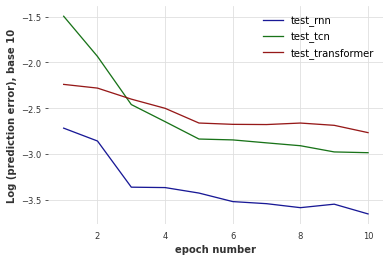

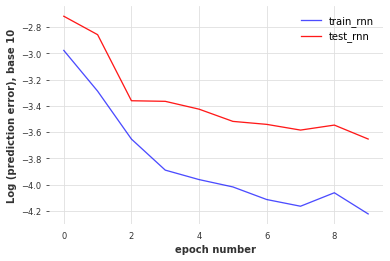

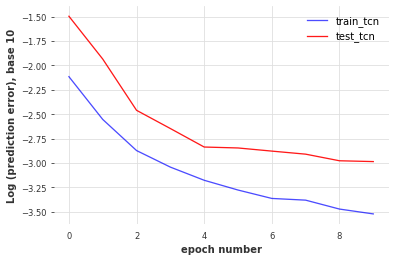

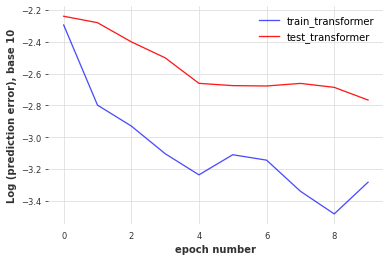

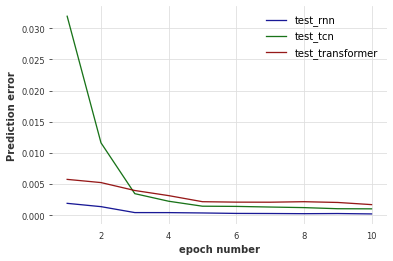

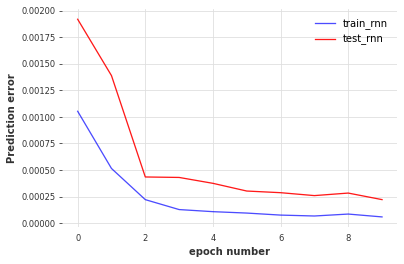

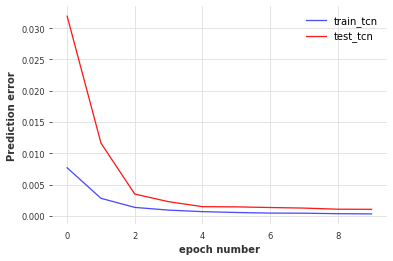

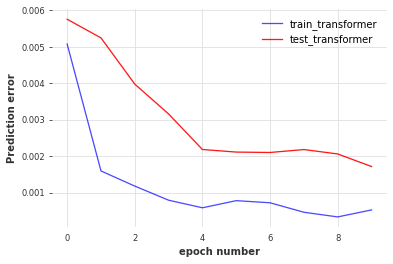


Printing models figures for JSB Chorales database:


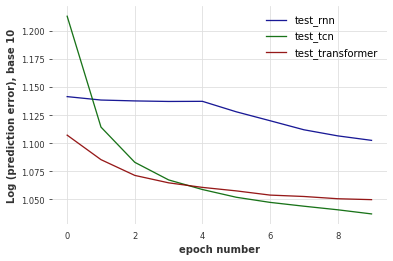

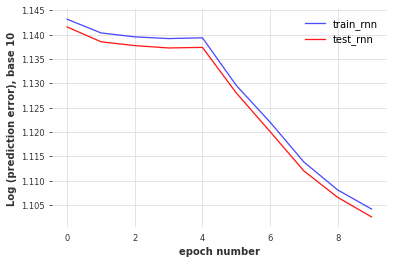

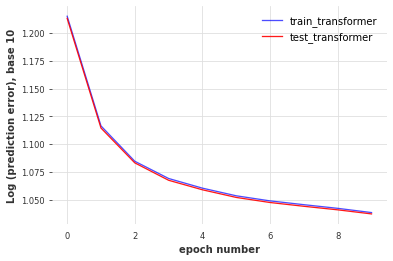

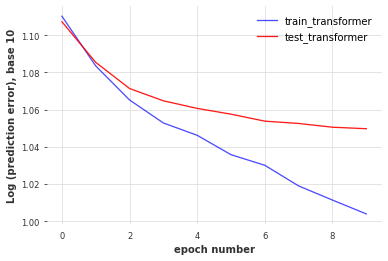

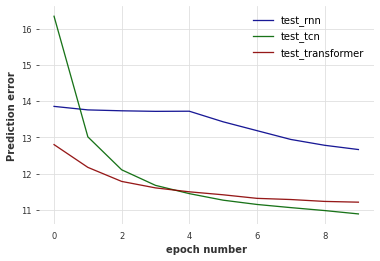

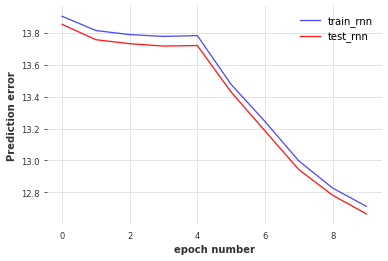

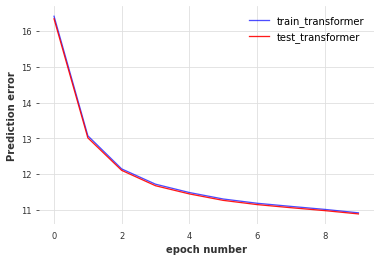

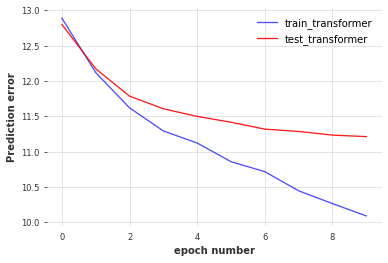

In [ ]:
print('Printing models figures for Exchange Rate database:')
plot_all_ex()
plot_all_ex(log10=False)
print()
print('Printing models figures for JSB Chorales database:')
plot_all_pytorch_jsb()
plot_all_pytorch_jsb(log10=False)